In [26]:
import random
import keras
import subprocess
import pickle
import keras_metrics as km
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.layers import Dense, Embedding, Dropout, LSTM, Activation, Conv1D, GlobalMaxPooling1D
from keras.models import Sequential
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import Callback

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize

from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.feature_extraction.text import TfidfVectorizer

tokenizer = Tokenizer()

In [2]:
def get_data(bot_file, gen_file):
    x_data = []
    with open(bot_file, 'r', errors='ignore') as file:
        for line in file:
            x_data.append(line)

    size = len(x_data)

    with open(gen_file, 'r', errors='ignore') as file:
        for line in file:
            x_data.append(line)

    y_data = [1] * size + [0] * size

    train_set = list(zip(x_data, y_data))
    random.shuffle(train_set)
    x, y = zip(*train_set)
    return np.array(x), np.array(y)

In [3]:
x, y = get_data('trv-bot.txt', 'trv-gen.txt')

In [4]:
x_test, y_test = get_data('test-bot.txt', 'test-gen.txt')

In [5]:
vec = TfidfVectorizer(max_features=100,
                      tokenizer=word_tokenize,
                      strip_accents='unicode',
                      lowercase =True,
                      analyzer='word',
                      token_pattern=r'\w+',
                      use_idf=True,
                      smooth_idf=True,
                      sublinear_tf=False, 
                      stop_words = 'english'
                     )
tfidf_mat = vec.fit_transform(x).toarray()
print(type(tfidf_mat),tfidf_mat.shape)

<class 'numpy.ndarray'> (640000, 100)


In [6]:
test_tfidf_mat = vec.transform(x_test).toarray()
print(type(test_tfidf_mat),test_tfidf_mat.shape)

<class 'numpy.ndarray'> (160000, 100)


In [63]:
model = Sequential()
model.add(Dense(512,input_shape=(100,), activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512,input_shape=(100,), activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512,input_shape=(100,), activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.summary()
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy',km.binary_precision(), km.binary_recall()]
)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 512)               51712     
_________________________________________________________________
dropout_11 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_12 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_13 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 512)               262656    
__________

In [64]:
history = model.fit(
    tfidf_mat,
    y,
    batch_size=128,
    epochs=20,
    verbose=1,
    validation_split=0.25
)

Train on 480000 samples, validate on 160000 samples
Epoch 1/20
480000/480000 [==============================] - 10s 20us/step - loss: 0.0973 - acc: 0.9663 - precision: 0.9698 - recall: 0.9627 - val_loss: 0.0900 - val_acc: 0.9644 - val_precision: 0.9943 - val_recall: 0.9341
Epoch 2/20
480000/480000 [==============================] - 9s 18us/step - loss: 0.0873 - acc: 0.9696 - precision: 0.9713 - recall: 0.9678 - val_loss: 0.0859 - val_acc: 0.9696 - val_precision: 0.9683 - val_recall: 0.9709
Epoch 3/20
480000/480000 [==============================] - 9s 18us/step - loss: 0.0846 - acc: 0.9706 - precision: 0.9723 - recall: 0.9687 - val_loss: 0.0861 - val_acc: 0.9708 - val_precision: 0.9715 - val_recall: 0.9700
Epoch 4/20
480000/480000 [==============================] - 9s 18us/step - loss: 0.0828 - acc: 0.9711 - precision: 0.9725 - recall: 0.9696 - val_loss: 0.0833 - val_acc: 0.9709 - val_precision: 0.9734 - val_recall: 0.9681
Epoch 5/20
480000/480000 [==============================] - 9s 

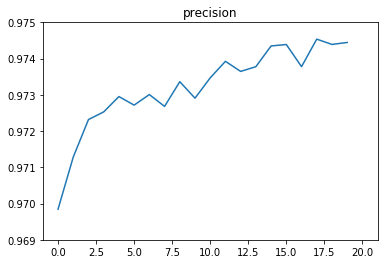

In [84]:
plt.xlim(left=-1, right=21)
plt.ylim(bottom=0.969, top=0.975)
plt.title('precision')
plt.plot(history.history['precision'], label='train')
plt.savefig('tfidf-s-1/precision.svg')

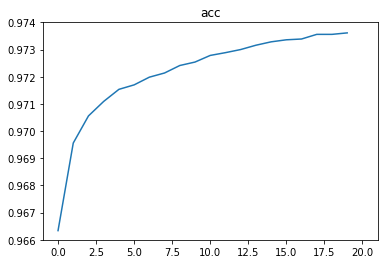

In [86]:
plt.xlim(left=-1, right=21)
plt.ylim(bottom=0.966, top=0.974)
plt.title('acc')
plt.plot(history.history['acc'], label='train')
plt.savefig('tfidf-s-1/accuracy.svg')

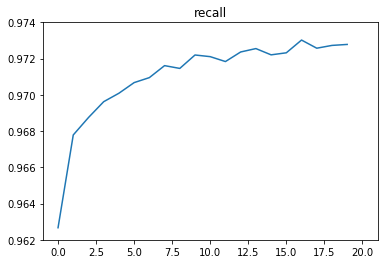

In [89]:
plt.xlim(left=-1, right=21)
plt.ylim(bottom=0.962, top=0.974)
plt.title('recall')
plt.plot(history.history['recall'], label='train')
plt.savefig('tfidf-s-1/recall.svg')

In [90]:
y_pred = model.predict(test_tfidf_mat).ravel()
fpr, tpr, threshold = roc_curve(y_test, y_pred)

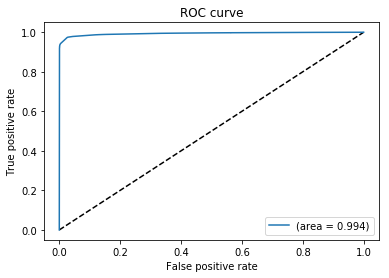

In [91]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='(area = {:.3f})'.format(auc(fpr, tpr)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.savefig('tfidf-s-1/roc.svg')

In [92]:
score, acc, p, r = model.evaluate(test_tfidf_mat, y_test)
print('score:', score)
print('accuracy:', acc)
print('precision:', p)
print('recall:', r)

160000/160000 [==============================] - 3s 21us/step
score: 0.08000907635651529
accuracy: 0.9736625
precision: 0.9733903005759521
recall: 0.9739499999987825


In [93]:
model.save_weights("tfidf-s-1/model.h5")
print("Saved model to disk")

Saved model to disk
